#Arctic freshwater analysis

In [1]:
import glob
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import cm
from mpl_toolkits.basemap import Basemap
#from mpl_toolkits.basemap import shiftgrid
% matplotlib inline

$$
FWC = \int^{0}_{z_{lim}}{\left( 1-\frac{S(z)}{S_{ref}} \right)dz}
$$

* $S_{ref}$ is 34.8 as the end-member of Atlantic water
* $S(z)$ is the salinity profile as a function of $z$
* $z_{lim}$ first level of $S\left(z_{lim}\right)=S_{ref}$

In [62]:
def fwc_1d(S, z, Sref):
    if S[0] < Sref:
        id_lim = np.searchsorted(S, Sref, 'left')
        return np.sum((1-S[:id_lim]/Sref)*z[:id_lim])
    else:
        return np.nan
def fwc_2d(S, z, Sref):
    fwc = np.empty(S.shape)[0, :, :]
    for i in range(np.size(S, 1)):
        for j in range(np.size(S, 2)):
            fwc[i, j] = fwc_1d(S[:, i, j], z, Sref)
    return fwc

# 1996 - 2005 Climatology

In [3]:
JJA_name=glob.glob('_data/Reanalysis/WOA/*s13*.nc')
print("found file: \n{}".format(JJA_name))
DJF_name=glob.glob('_data/Reanalysis/WOA/*s15*.nc')
print("found file: \n{}".format(DJF_name))

found file: 
['_data/Reanalysis/WOA\\woa13_95A4_s13_01.nc']
found file: 
['_data/Reanalysis/WOA\\woa13_95A4_s15_01.nc']


In [5]:
JJA_obj=nc.Dataset(JJA_name[0])
DJF_obj=nc.Dataset(DJF_name[0])
print('Variables in {}:\n==========\n{}'.format(JJA_name[0], JJA_obj.variables.keys()))

Variables in _data/Reanalysis/WOA\woa13_95A4_s13_01.nc:
[u'crs', u'lat', u'lat_bnds', u'lon', u'lon_bnds', u'depth', u'depth_bnds', u'time', u'climatology_bounds', u's_an', u's_mn', u's_dd', u's_sd', u's_se', u's_oa', u's_ma', u's_gp']


In [11]:
lon=JJA_obj.variables['lon'][:]
lat=JJA_obj.variables['lat'][:]
JJA=JJA_obj.variables['s_an'][:]
DJF=DJF_obj.variables['s_an'][:]
depth=JJA_obj.variables['depth'][:]
longitude, latitude = np.meshgrid(lon, lat)

In [49]:
fwc_JJA = fwc_2d(JJA[0, :, :, :], depth, 34.8)
fwc_DJF = fwc_2d(DJF[0, :, :, :], depth, 34.8)

In [50]:
fwc_JJA_mask = np.ma.masked_where(np.isnan(fwc_JJA), fwc_JJA)
fwc_DJF_mask = np.ma.masked_where(np.isnan(fwc_DJF), fwc_DJF)

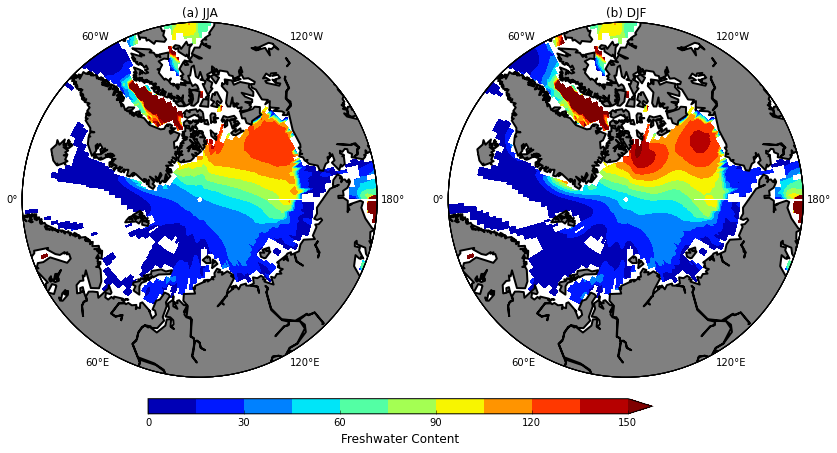

In [63]:
fig = plt.figure(figsize=(14, 14))
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

proj=Basemap(projection='npstere', resolution='c', boundinglat=60, lon_0=90, round=True, ax=ax1)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=2.0, linestyle='-', color='k')
x, y=proj(longitude, latitude)
CS = proj.contourf(x, y, fwc_JJA_mask, range(0, 165, 15), extend='max')
ax1.set_title('(a) JJA')

ax = fig.gca()
proj=Basemap(projection='npstere', resolution='c', boundinglat=60, lon_0=90, round=True, ax=ax2)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=2.0, linestyle='-', color='k')
x, y=proj(longitude, latitude)
CS = proj.contourf(x, y, fwc_DJF_mask, range(0, 165, 15), extend='max')
ax2.set_title('(b) DJF')

cax  = fig.add_axes([0.25, 0.3, 0.5, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Freshwater Content', fontsize=12)